# MCSim Test
## Class MCVar
## Class MCVector
## Calculation with fourier noise according to https://doi.org/10.1088/1681-7575/aa7b39

In [1]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from luxpy import _CMF, plot_spectrum_colors, _CIE_ILLUMINANTS
from luxpy.color.utils import plot_cmfs, plot_color_data
from luxpy.toolboxes.photbiochem import _BLH, Km_correction_factor
from luxpy.toolboxes.photbiochem import _ACTIONSPECTRA_CIES026
from luxpy.toolboxes.indvcmf import add_to_cmf_dict
from luxpy.spectrum import spd_to_xyz

from empir19nrm02 import _SPD, _RES
from empir19nrm02.tools import  plot_2D, plotCorrMatrixSmall, sumMC
from empir19nrm02.tools.help import plotCorrelation, display_color_diagram, display_spectra
from empir19nrm02.MC import McVar, DistributionParam, NameUnit, MCVectorVar, generate_FourierMC0, py_getBaseFunctions, noise_list_default, pickle_copy
from empir19nrm02.MC import load_from_excel, save_to_excel, save_to_csv


from numpy import ndarray

import pandas as pd

print('Version of luxpy:', lx.__version__)
out_dir = 'MCSim_Test'

import os
print( 'CWD:', os.getcwd())

Version of luxpy: v1.10.0
CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


In [2]:
def plotMCResult( wl, mcVar, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g-'
    else:
        if diagnumber == 1:
            color1 = 'r--'
            color2 = 'g--'
        else:
            color1 = 'r-.'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVar.v_mean/np.max(mcVar.v_mean), color1, label= title + ' $s_{\mathrm{rel}}(\lambda)$')
    ax2.plot(wl, mcVar.v_std / mcVar.v_mean, color2, label= title + ' $u_{\mathrm{rel}}(s_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(strd['xlambda'])
    ax1.set_ylabel('Signal / A.U', color = 'red')
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green')
    if title:
        ax1.set_title(title)
    fig.legend()
    return fig, ax1, ax2

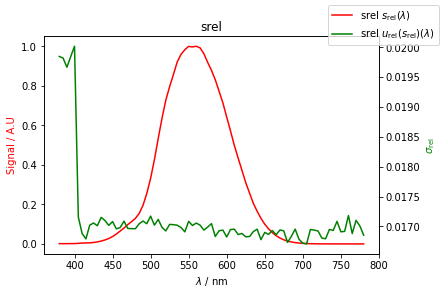

In [3]:
filenameTest = 'srel'
wl, mcVar = load_from_excel(filename = out_dir + '/' + filenameTest,
                            wlColumn=0, valColumn=1, covColumn=2)

plotMCResult(wl, mcVar, title=filenameTest)
save_to_excel(wl, mcVar, filename = out_dir + '/' + filenameTest)
save_to_csv(wl, mcVar, filename = out_dir + '/' + filenameTest)
save_fig(out_dir, filenameTest)


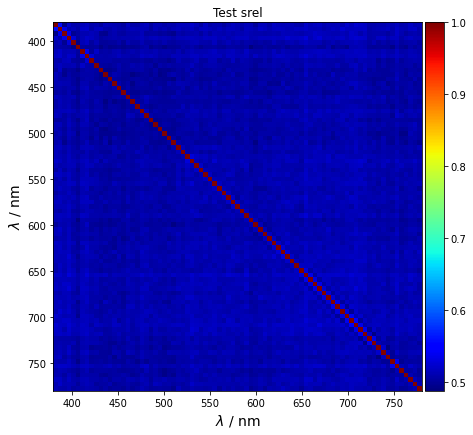

In [4]:
plotCorrelation(mcVar.corr_matrix, wl, 'Test ' + filenameTest)
save_fig(out_dir, 'Corr_' + filenameTest)


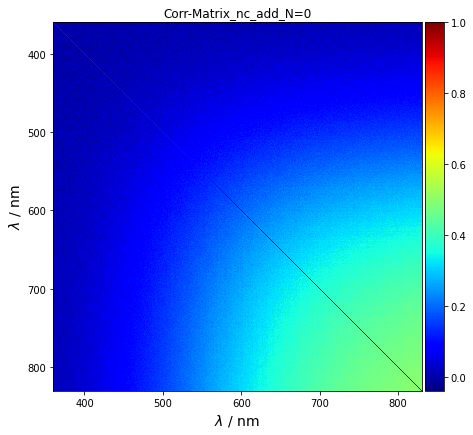

0 [2855.571272664577, 7.239752319518126] [2841.3322420294003, 2869.7316014042885] 14.199679687444132


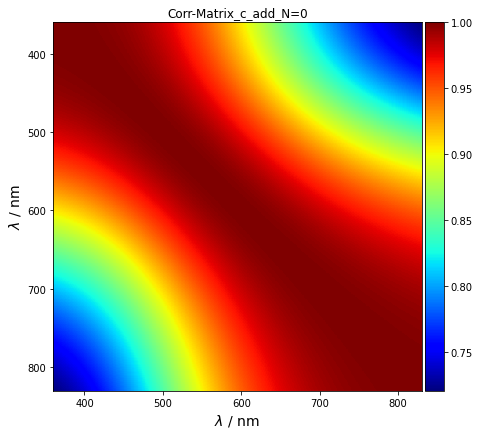

0 [2854.6662029611116, 36.73696460601696] [2781.689615673513, 2926.4774833833794] 72.39393385493327


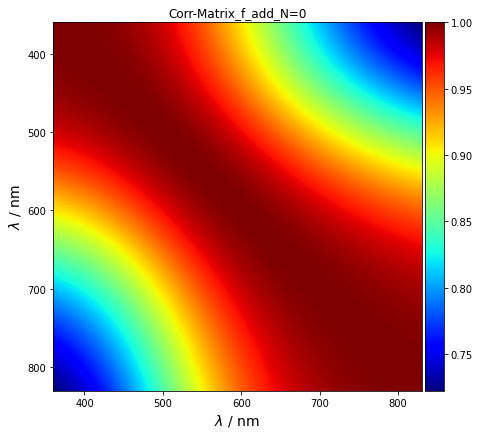

0 [2855.070152331406, 36.94518200801936] [2780.2041574096975, 2927.102420116852] 73.44913135357729


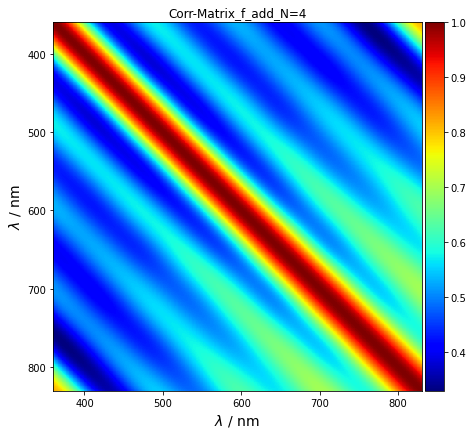

4 [2856.1372437251994, 60.17407866837896] [2745.1757074055663, 2968.735572762328] 111.77993267838087


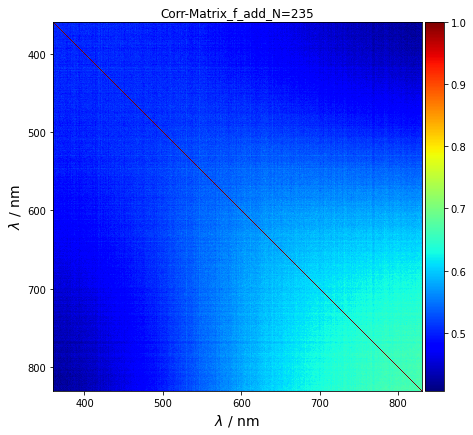

235 [2854.866599965921, 37.86213990317025] [2778.034013391581, 2926.678610600297] 74.32229860435791


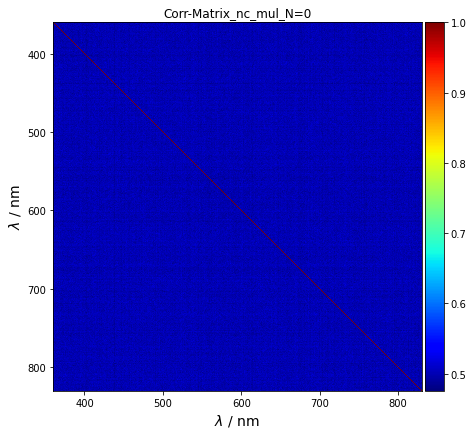

0 [2855.5129429722006, 2.6648201542869145] [2850.2956167063335, 2860.7086613895663] 5.206522341616392


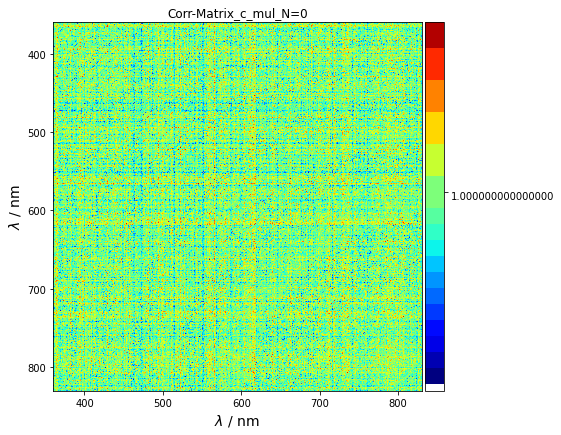

0 [2855.54268804374, 1.1106639669586522e-12] [2855.542688043739, 2855.542688043743] 2.0463630789890885e-12


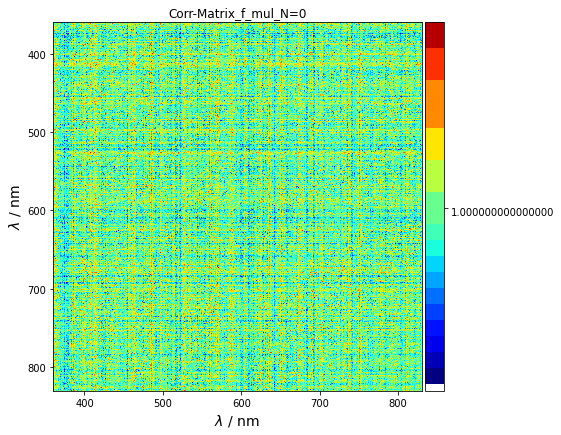

0 [2855.54268804374, 1.1077089153499883e-12] [2855.542688043739, 2855.542688043743] 2.0463630789890885e-12


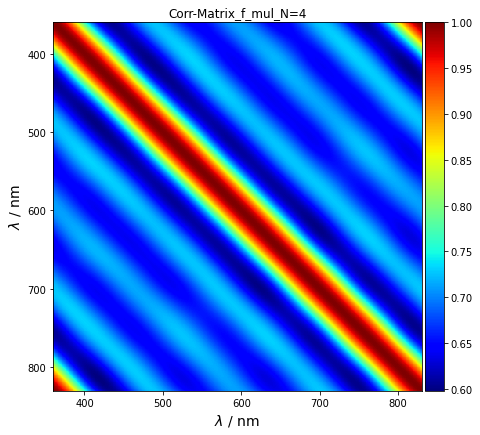

4 [2855.3794194061907, 18.24488301296007] [2820.9623790256474, 2890.193521944127] 34.615571459239845


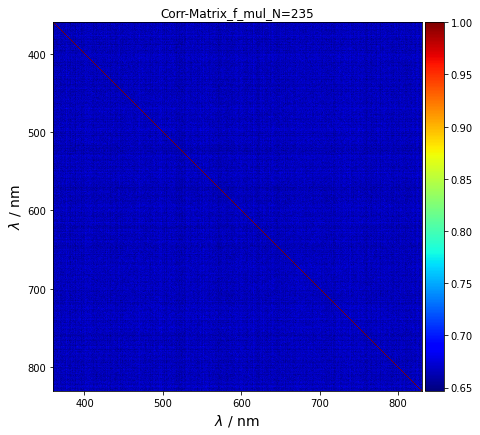

235 [2855.5204029001115, 2.673416385117648] [2850.176563872673, 2860.7917390938296] 5.307587610578366


In [5]:
wl_scale = np.arange(360,830+1,1)
lxSpdInterpolate = lx.cie_interp(lx._CIE_ILLUMINANTS['A'], wl_new = wl_scale, kind = 'S')
lxSpdInterpolate[1] = lxSpdInterpolate[1] / np.max(lxSpdInterpolate[1])
elements = wl_scale.shape[0]
zeros = np.ones_like(lxSpdInterpolate[0])
elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,47, 50,60,70,80,90,100,150,200,235]

elements2Run = [0, 4,235]

def tmpRun(key, N, mcValue):
    mcValue.set_vector_param(lxSpdInterpolate[1], v_std=zeros)
    mcValue.generate_numbers()
    str_description = 'Corr-Matrix_' + key + '_N='+str(N)
    plotCorrelation(mcValue.corr_matrix, wl_scale, str_description)
    save_fig(out_dir, filename=str_description)
    tmp_data = np.vstack((wl_scale, mcValue.val))
    XYZ = lx.spd_to_xyz( tmp_data, relative=False, cieobs='1931_2')
    CCT = lx.xyz_to_cct(XYZ)
    [CCTvalues, CCTinterval] = sumMC(CCT, Coverage=0.95)
    print( N, CCTvalues, CCTinterval, (CCTinterval[1]-CCTinterval[0])/2)

for key in noise_list_default:
    if 'f_' in key:
        for N in elements2Run:
            mcValue = MCVectorVar(name=NameUnit('Signal', 'A.U.'), elements=elements, noise_list={ key: DistributionParam(mean = 0, stddev = .01, distribution = 'normal', add_params = N)})
            tmpRun( key, N, mcValue)
    else:
        mcValue = MCVectorVar(name=NameUnit('Signal', 'A.U.'), elements=elements, noise_list={ key: DistributionParam(mean = 0, stddev = .01, distribution = 'normal')})
        tmpRun( key, 0, mcValue)



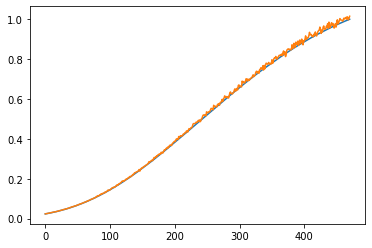

In [6]:

pyplot.plot( mcValue.val[0])
pyplot.plot( mcValue.val[1])

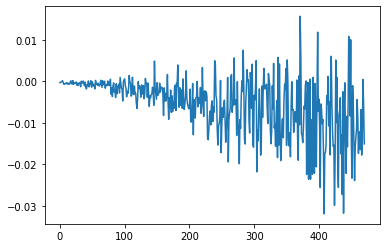

In [7]:

pyplot.plot( mcValue.val[0]-mcValue.val[1])


# Test Class MCVar

In [8]:
var1 = McVar(name=NameUnit('var1', 'Unit_var1'), distribution=DistributionParam())
var1.generate_numbers()
var1.print_stat()
var1.pickle()

var1Load = McVar(name=NameUnit('var1Load', 'Unit_var1Load'))
var1Load.unpickle('var1')
var1Load.print_stat(out_all=True)

var2 = McVar(name=NameUnit('var2', 'Unit_var2'),
             distribution=DistributionParam(mean=1, stddev=2, distribution='triangle', add_params=4))
var2.generate_numbers()
var2.print_stat(out_all=True)
var2.pickle()

var2Load = McVar()
var2Load.unpickle('var2')
var2Load.print_stat(out_all=True)

var2Load.generate_numbers(file='var1')
var2Load.print_stat(out_all=True)

Name: var1 NameUnit(name='var1', unit='Unit_var1') Values: [-0.0017702378748867432, 0.996136249992026] Interval: [-1.968721144168319, 1.9483295081591157]
Name: var1Load NameUnit(name='var1', unit='Unit_var1') Values: [-0.0017702378748867432, 0.996136249992026] Interval: [-1.968721144168319, 1.9483295081591157]
    trials: 10000 step: 0 Distribution: Distribution: Mean:0.0000, StdDev: 1.0000, Dist: normal, Add_Param: None
Name: var2 NameUnit(name='var2', unit='Unit_var2') Values: [1.0140962246538103, 2.009244141319596] Interval: [-2.8025743594847774, 4.806938320009603]
    trials: 10000 step: 0 Distribution: Distribution: Mean:1.0000, StdDev: 2.0000, Dist: triangle, Add_Param: 4
Name: var2Load NameUnit(name='var2', unit='Unit_var2') Values: [1.0140962246538103, 2.009244141319596] Interval: [-2.8025743594847774, 4.806938320009603]
    trials: 10000 step: 0 Distribution: Distribution: Mean:1.0000, StdDev: 2.0000, Dist: triangle, Add_Param: 4
Name: var2Load NameUnit(name='var2', unit='Unit

# Test Class McVector

In [9]:
var1V = MCVectorVar(name=NameUnit('var1', 'Unit_var1'))

v_mean = np.zeros((2))
v_std = np.ones((2))*2
v_std[0] = 1.5

var1V.set_vector_param(v_mean, v_std)
var1V.generate_numbers()
var1V.print_stat()
var1V.pickle()

var2V = MCVectorVar(name=NameUnit('var2', 'Unit_var2'))
var2V.generate_numbers(file='var1V')
var2V.print_stat()
plot_2D(var2V, number=1000)

var3V = var1V
v_mean[0] = 2
v_mean[1] = 3
corr = np.eye(2, dtype=float)
corr[0,1] = -0.7
corr[1,0] = -0.7
var3V.set_vector_param(v_mean=v_mean, v_std=v_std, corr=corr)
var3V.generate_numbers()
var3V.print_stat()
plot_2D(var3V, number=1000)
plotCorrMatrixSmall(var3V.corr_matrix, ['x', 'y'])


Name: var1V NameUnit(name='var1', unit='Unit_var1') Values: [array([-2.8909e-03, 6.1530e-03]), array([1.5015e+00, 2.0221e+00])] Interval: [array([-2.9554e+00, -3.9590e+00]), array([2.9948e+00, 3.9293e+00])]
Corr: [[1.0000e+00 -9.1194e-03]
 [-9.1194e-03 1.0000e+00]] Cov: [[2.2552e+00 -2.7694e-02]
 [-2.7694e-02 4.0892e+00]]


AxisError: axis 0 is out of bounds for array of dimension 0

# Test Fourier Noise according to https://doi.org/10.1088/1681-7575/aa7b39

## Generate some base functions (Fig. 1)

In [ ]:
base_function_steps = 100
for number_base in range(5):
    baseFunctions = py_getBaseFunctions(number_base, base_function_steps, np.zeros((number_base+1)))
    pyplot.plot( baseFunctions)
    print( np.std(baseFunctions))

## Generate the real $\delta(\lambda)*u_c$ functions (part if equation (8))

org_function:
True: equal to the paper
False: special handling of the full correlated term gamma_0

In [ ]:
for number_base in range(5):
    baseFunctions = generate_FourierMC0(number_base, base_function_steps, 0.01, org_function=True)
    pyplot.plot( baseFunctions)
    print( np.std(baseFunctions))


In [ ]:
for number_base in range(5):
    baseFunctions = generate_FourierMC0(number_base, base_function_steps, 0.01, org_function=False)
    pyplot.plot( baseFunctions)
    print( np.std(baseFunctions))

## Generalte some base functions and check the standard deviation at each wavelength

In [ ]:
trials = 1000
baseFunctions = np.zeros((trials, base_function_steps))
number_base = 10
for i in range(trials):
    baseFunctions[i] = generate_FourierMC0(number_base, base_function_steps, 1, org_function=True)

std = np.std(baseFunctions, axis=0)
pyplot.plot( std )
print('The standard deviation should be equal to 1:', np.mean(std))

## Generate the Table 1 in the paper

In [ ]:
import pandas as pd
from empir19nrm02.tools import sumMC
elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,47, 50,60,70,80,90,100,150,200,235]

def FourierTableP( trials, wl, SPD, uSPD):
    wl_elements = wl.shape[0]
    print( wl_elements)
    #elements2Run = [10]
    petriTable = pd.DataFrame()
    rMatrixSPD = np.zeros((trials, wl.shape[0]))
    start_data =np.vstack((wl, SPD))
    XYZ = lx.spd_to_xyz( start_data, relative=False, cieobs='1931_2')
    Yxy = lx.xyz_to_Yxy (XYZ)
    print( Yxy)
    x0 = Yxy[0,1]
    y0 = Yxy[0,2]
    L0 = Yxy[0,0]
    CCT0 = lx.xyz_to_cct(XYZ)[0,0]
    print( CCT0)
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_FourierMC0( numberNew, wl_elements, uSPD, org_function=True)
            rMatrixSPD[j] = (1+rMatrix)*SPD
        tmp_data =np.vstack(( wl, rMatrixSPD))
        XYZ = lx.spd_to_xyz( tmp_data, relative=False, cieobs='1931_2')
        Yxy = lx.xyz_to_Yxy (XYZ, cieobs='1931_2')
        xData = Yxy[:, 1]
        yData = Yxy[:, 2]
        #pyplot.plot(xData, yData)
        L = Yxy[:, 0]
        CCT = lx.xyz_to_cct(XYZ)
        CCT.resize(trials)
        # Luminance
        [Lvalues, Linterval] = sumMC(L / L0, Coverage=0.95)
        #CCT
        [CCTvalues, CCTinterval] = sumMC(CCT, Coverage=0.95)
        #(x,y)
        [xvalues, xinterval] = sumMC(xData, Coverage=0.95)
        [yvalues, yinterval] = sumMC(yData, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'dL_mean': Lvalues[0], 'L_std': Lvalues[1], 'L_95%': (Linterval[1]-Linterval[0])/2., \
            'dCCT_mean': (CCTvalues[0]-CCT0), 'CCT_std': CCTvalues[1], 'CCT_95%': (CCTinterval[1] - CCTinterval[0]) / 2., \
            'dx_mean': xvalues[0]-x0, 'x_std': xvalues[1], 'x_95%': (xinterval[1] - xinterval[0]) / 2., \
            'dy_mean': yvalues[0]-y0, 'y_std': yvalues[1], 'y_95%': (yinterval[1] - yinterval[0]) / 2., \
             } , dtype = 'float')

        petriTable = pd.concat( [petriTable, df])
        print( numberNew, end=' ')
    return petriTable

In [ ]:
print( 'FourierTableP')

wl_scale = np.arange(360,830+1,1)
lxSpdInterpolate = lx.cie_interp(lx._CIE_ILLUMINANTS['A'], wl_new = wl_scale, kind = 'S')

uSPD=np.ones_like(lxSpdInterpolate[1])*0.01
#pyplot.plot( spd_init[0], uSPD)
petriTableP=FourierTableP(2000, lxSpdInterpolate[0], lxSpdInterpolate[1], uSPD)
petriTableP.to_excel(out_dir + '/' +  'FourierP.xlsx')
petriTableP

In [ ]:
eval = petriTableP[["N", "CCT_95%"]].to_numpy().T
numbers = eval.shape[1]
xNumber = range(numbers)
petriDataList = [0, 27.7, 36.3, 37.2, 35.5, 33.1, 30.6, 28.9, 27.3, 26.0, 25.1, 18.3, 15.1, 13.3, 12.1, 11.6, 10.8, 10.1, 9.2, 8.8, 8.4, 6.8,6.0,5.6]
fig = pyplot.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_xlabel(r"number of the investigation",fontsize=label_font_size)
ax1.set_ylabel('U(CCT)',fontsize=label_font_size)
ax1.plot(xNumber, eval[1], label='Python')
ax1.plot(xNumber, petriDataList, label='Metrologia')

new_tick_locations = range( numbers)
def tick_function(X):
    return ["%d" % elements2Run[z] for z in X]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Number of base functions",fontsize=label_font_size)
ax1.legend()
save_fig(out_dir, 'MetCompCCT_Table1')